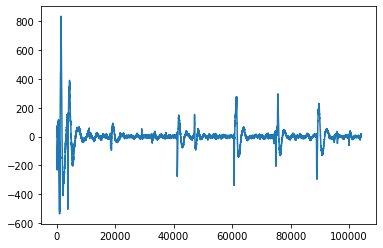

In [2]:
import numpy as np
import pickle
import pandas as pd
import statsmodels.api as sm
import hdf5storage
from scipy.signal import butter, lfilter
import os, glob, time
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from datetime import datetime
from sklearn.externals import joblib
from scipy import signal
import matplotlib.pyplot as plt
import random
%matplotlib inline

def Re_referencing(eegData, channelNum, sampleNum):
        after_car = np.zeros((channelNum,sampleNum))
        for i in np.arange(channelNum):
            after_car[i,:] = eegData[i,:] - np.mean(eegData,axis=0)
        return after_car
    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            # Baseline Correction
            for i in range(nChannel):
                Epochs[j, i, :] = np.subtract(Epochs[j, i, :], np.mean(eegData[i,Time_after[j]:Time_base[j]]))
                
        return [Epochs, Num[0]]

def Make_Average_Component(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, componentNum):
    NumT_Aver = NumT-componentNum
    NumN_Aver = NumN-componentNum
    
    EpochsT_Aver = np.zeros((NumT_Aver, channelNum, epochSampleNum))
    EpochsN_Aver = np.zeros((NumN_Aver, channelNum, epochSampleNum))
    for i in range(NumT_Aver):
        EpochsT_Aver[i, :, :] = np.mean(EpochsT[i:i+componentNum, :, :], axis=0)
    for j in range(NumN_Aver):
        EpochsN_Aver[j, :, :] = np.mean(EpochsN[j:j+componentNum, :, :], axis=0)
        
    return [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver]    
    
def Convert_to_featureVector(EpochsT, NumT, EpochsN, NumN, featureNum):
        FeaturesT = np.zeros((NumT, featureNum))
        for i in range(NumT):
            FeaturesT[i,:] = np.reshape(EpochsT[i,:,:],(1,featureNum))
        FeaturesN = np.zeros((NumN, featureNum))
        for j in range(NumN):
            FeaturesN[j,:] = np.reshape(EpochsN[j,:,:],(1,featureNum))
        return [FeaturesT,FeaturesN]

def resampling(Epochs, EpochNum, resampleRate, channelNum):
        resampled_epoch = np.zeros((EpochNum, channelNum, resampleRate))
        for i in range(EpochNum):
            for j in range(channelNum):
                resampled_epoch[i,j,:] = signal.resample(Epochs[i,j,:], resampleRate)
        return resampled_epoch

def main():
        start = time.time()
        
        ##Generate Preprocessing Training data
        ctime = datetime.today().strftime("%m%d_%H%M")
        Classifier_path = 'C:\\Users\\hyuns\\Desktop\\2020-2\\캡스톤\\LDAModel\\General\\' + ctime + 'Classifier.pickle'
        
        root_path = 'C:\\Users\\hyuns\\Desktop\\2020-2\\캡스톤\\EEGData\\VR300\\0729\\hs\\'
#         root_path = 'C:\\Users\\hyuns\\Desktop\\2020-2\\캡스톤\\EEGData\\VR300\\실험데이터\\S15\\'
        mat_path = root_path + 'Training\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
        
        matfile_name = current_list[0]
        
        mat = hdf5storage.loadmat(matfile_name)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)
        
        ##Preprocessing process
        sampleNum = eegData.shape[1]
        
        #Common Average Reference
        eegData = Re_referencing(eegData, channelNum, sampleNum)
        
        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.1, 30, samplingFreq, order=4)
        
        plt.plot(eegData[0,:])
        plt.show()
        
        
        #Epoching & Baseline Correction 
        epochSampleNum = int(np.floor(1.0 * samplingFreq))
        offset = int(np.floor(0.0 * samplingFreq)) 
        baseline = int(np.floor(1.0 * samplingFreq)) 
        [EpochsT, NumT] = Epoching(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        resampleRate = 100
        
        [EpochsT, NumT, EpochsN, NumN] = Make_Average_Component(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, 20)
        EpochsT = resampling(EpochsT, NumT, resampleRate, channelNum) 
        EpochsN = resampling(EpochsN, NumN, resampleRate, channelNum)
        
        # vr300 7 channel
        # [P4, Fz, Pz, P3, PO8, PO7, Oz]
        
        channels = ['P4', 'Fz', 'Pz', 'P3', 'PO8', 'PO7', 'Oz']
        plotdata_T = np.mean(EpochsT, axis=0)
        plotdata_T = np.mean(plotdata_T, axis=0)
#         for i in range(7):
#         plt.plot(plotdata_T)
#         plt.title('Target Data')
# #         plt.legend(channels)
#         plt.show()
            
        plotdata_N = np.mean(EpochsN, axis=0)
        plotdata_N = np.mean(plotdata_N, axis=0)
#         for i in range(7):
#         plt.plot(plotdata_N)
#         plt.title('Non-Target Data')
# #         plt.legend(channels)
#         plt.show()
    
    
#         plt.plot(plotdata_T)
#         plt.plot(plotdata_N)
#         plt.title('Target, Non-Target Comparison')
#         plt.legend(['Target', 'Non-Target'])
#         plt.show()
            
if __name__ == "__main__":
    main()

C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\49_5.mat
Online Session 1


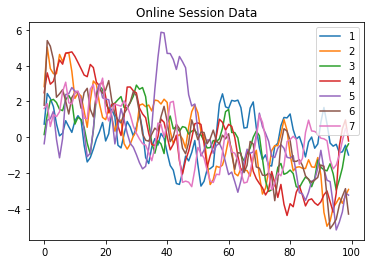

C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\48_5.mat
Online Session 2


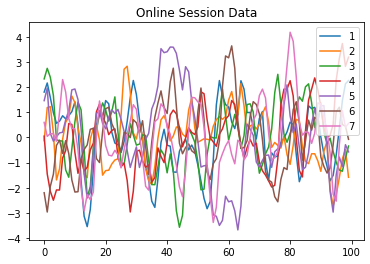

C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\47_1.mat
Online Session 3


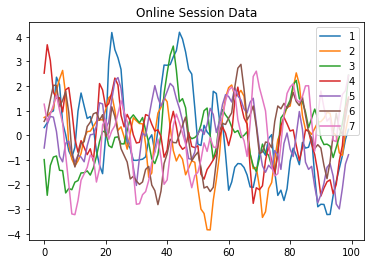

C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\46_7.mat
Online Session 4


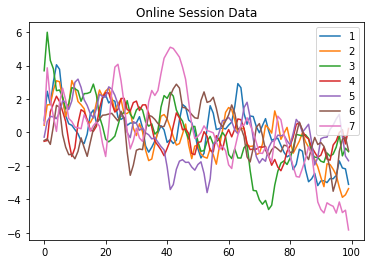

C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\45_6.mat
Online Session 5


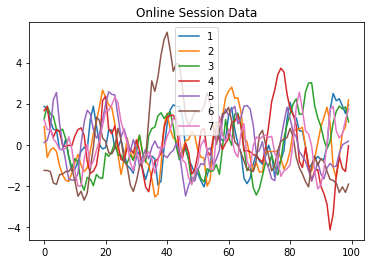

C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\44_6.mat
Online Session 6


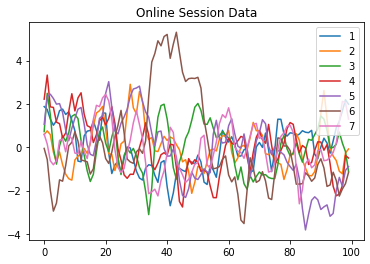

C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\43_4.mat
Online Session 7


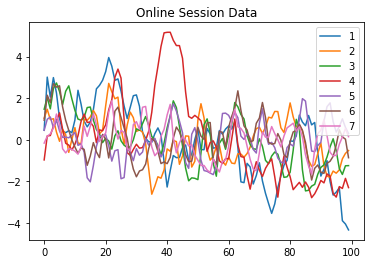

C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\42_2.mat
Online Session 8


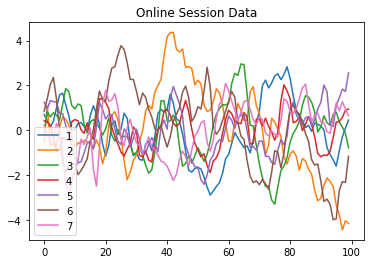

C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\41_1.mat
Online Session 9


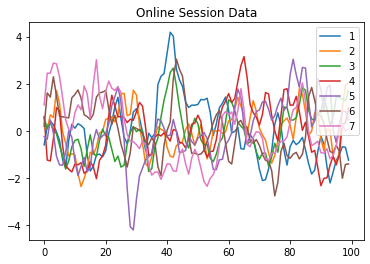

C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\40_7.mat
Online Session 10


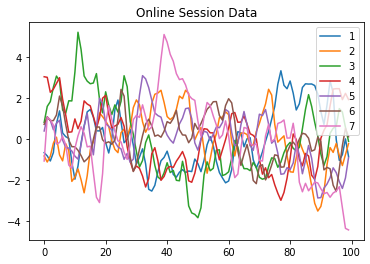

C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\39_2.mat
Online Session 11


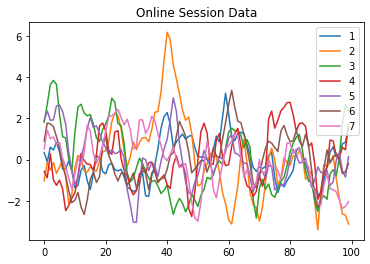

C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\38_1.mat
Online Session 12


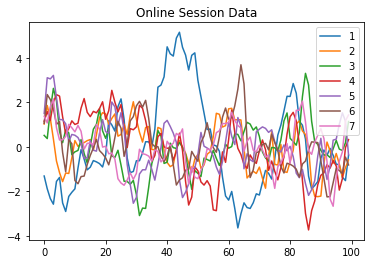

C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\37_1.mat
Online Session 13


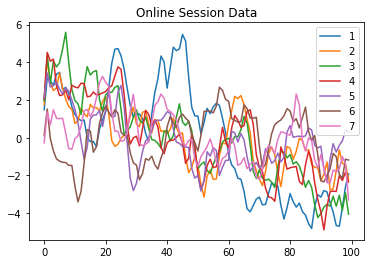

C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\36_3.mat
Online Session 14


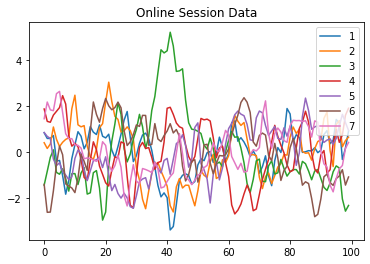

C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\35_3.mat
Online Session 15


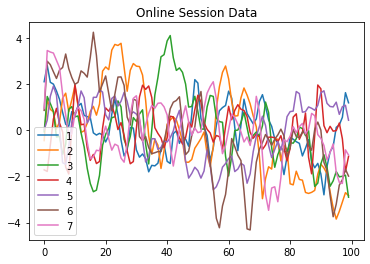

C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\34_4.mat
Online Session 16


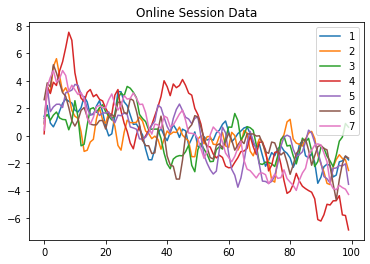

C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\33_6.mat
Online Session 17


KeyboardInterrupt: 

In [25]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.externals import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt

def Re_referencing(eegData, channelNum, sampleNum):
        after_car = np.zeros((channelNum,sampleNum))
        for i in np.arange(channelNum):
            after_car[i,:] = eegData[i,:] - np.mean(eegData,axis=0)
        return after_car
    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
    
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])

        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
    
def Convert_to_FeatureVector(Epochs, buttonNum, featureNum):
    Features = np.zeros((buttonNum, featureNum))
    for i in range(buttonNum):
        Features[i, :] = np.reshape(Epochs[i, :, :], (1, featureNum))
    return Features

def resampling(Epochs, resampleRate, channelNum):
        resampled_epoch = np.zeros((channelNum, resampleRate))
        for j in range(channelNum):
            resampled_epoch[j,:] = signal.resample(Epochs[j,:], resampleRate)
            
        return resampled_epoch
    
def main():
        root_path = 'C:\\Users\\hyuns\\Desktop\\2020-2\\캡스톤\\EEGData\\VR300\\0729\\hs\\'
#         root_path = 'C:\\Users\\hyuns\\Desktop\\2020-2\\캡스톤\\EEGData\\VR300\\실험데이터\\S15\\'
        
        mat_path = root_path + 'Online\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
        count = 1
        for mat_file in current_list:
            print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, 0.1, 30, samplingFreq, order=4)

            #Epoching
            epochSampleNum = int(np.floor(1.0 * samplingFreq))
            offset = int(np.floor(0.0 * samplingFreq))
            baseline = int(np.floor(1.0 * samplingFreq))
            resampleRate = 100
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            Epochs_final = np.zeros((buttonNum, channelNum, resampleRate))
            
            featureNum = channelNum*resampleRate
            
            for i in range(buttonNum):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                Epochs_final[i] = resampling(Epochs_Aver[i], resampleRate, channelNum)
            
            print('Online Session ' + str(count))
            for i in range(buttonNum):
                plotdata = np.mean(Epochs_final[i], axis=0)
                plt.plot(plotdata)
#                 plt.title('Button ' + str(i+1))
                plt.title('Online Session Data')
            plt.legend(['1','2','3','4','5','6','7'])
            plt.show()
            
            count += 1
    
if __name__ == "__main__":
    main()